### 尝试训练1 ：Age & Gender classification task
- 采用CNN模型，同时尝试利用从Imagenet微调的resnet 或 mobilenet进行训练
- 其中尝试了one-cycle训练方法
- 因为本次训练的目的是找出最合适的网络模型，为简单起见，我们没有使用五折交叉验证，而是按9：1随机划分训练或者验证集


In [1]:
# install needed packages
#!pip install torch numpy opencv-python matplotlib albumentations

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import sys
import time
from pathlib import Path
import json
import matplotlib.pyplot as plt
%matplotlib inline

import albumentations as albu
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2

# fix random seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"python version {sys.version}, pytorch version {torch.__version__}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name('cuda')}")

c:\ProgramData\Anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


python version 3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)], pytorch version 1.11.0
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


选择快速变换库：[Albumentations](https://github.com/albumentations-team/albumentations)进行数据增强



In [2]:
#ROOT = Path("aligned")
ROOT = Path("E:/resource/dataset/Adience/aligned/aligned")
labels = json.load(ROOT.joinpath("labels.json").open())

In [3]:
def show_img(image):
    plt.figure(figsize=(12, 10))
    plt.imshow(image)
    plt.show()

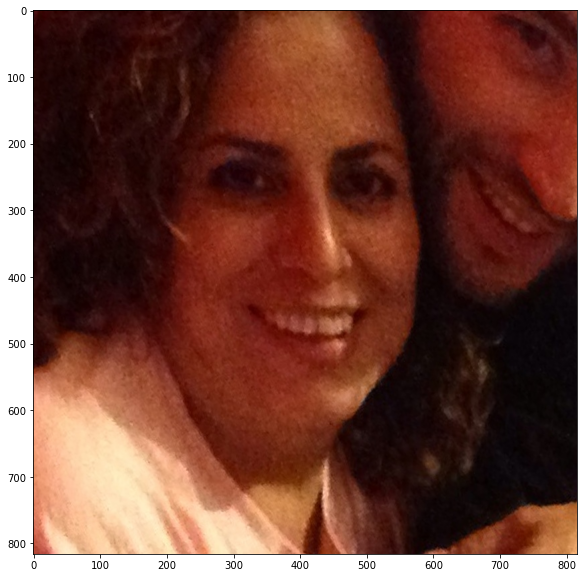

In [4]:
im = cv2.imread(str(ROOT.joinpath(list(labels)[500])))[..., ::-1]
show_img(im)

In [5]:
# define train transforms and valid transforms

# height, width
image_size = (224, 224)

augmentations = [
    albu.RandomResizedCrop(*image_size, scale=(0.6, 1)),
    albu.HorizontalFlip(),
    albu.RandomBrightnessContrast(),
    albu.OneOf([
        albu.CLAHE(),
        albu.Blur(5),
        albu.RGBShift()  
    ], p=1),
]

# for debugging purposes only
show_transforms = albu.Compose(augmentations)

train_transforms = albu.Compose([
    *augmentations,
    albu.Normalize(),
    ToTensorV2()
])

valid_transforms = albu.Compose([
    albu.Resize(*(np.array(image_size) * 1.25).astype(int)),
    albu.CenterCrop(*image_size),
    albu.Normalize(),
    ToTensorV2()
])

In [6]:
%%timeit
transformed = show_transforms(image=im)['image']

3.08 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


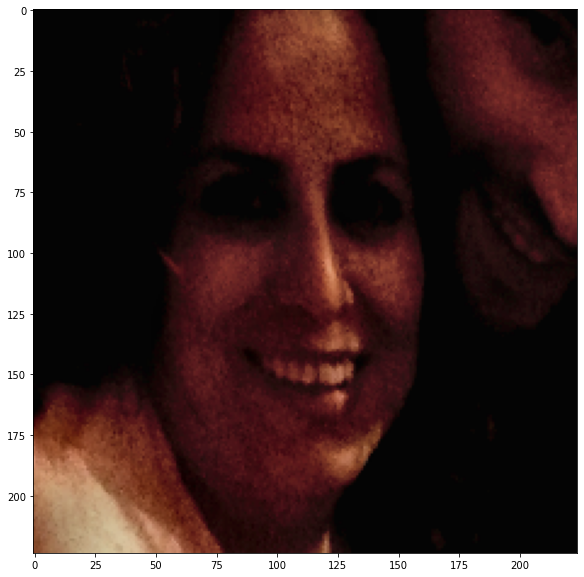

In [7]:
show_img(show_transforms(image=im)['image'])

In [8]:
class AgeGenderDataset(Dataset):
    """Very simple dataset for age&gender task"""
    def __init__(self, root, items, transform):
        self.root = root
        self.items = items
        self.transform = transform
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        filepath, meta = self.items[idx]
        img = cv2.imread(str(self.root.joinpath(filepath)))[..., ::-1]
        img = self.transform(image=img)['image']
        age_id, gender_id = torch.tensor(meta['age_id']), torch.tensor(meta['gender_id'])
        return img, (age_id, gender_id)


In [9]:
class AgeGenderModel(nn.Module):
    """
    CNN model with 2 heads and SE-block
    with multitask model learns faster
    """
    def __init__(self, encoder, encoder_channels, 
                 age_classes, gender_classes, output_channels=512):
        super().__init__()
        
        # encoder features (resnet50 in my case)
        # output should be bs x c x h x w
        self.encoder = encoder
        
        # sqeeze-excite
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.downsample = nn.Conv2d(encoder_channels, output_channels, 1)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.nonlin1 = nn.ReLU()
        
        self.excite = nn.Conv2d(output_channels, output_channels, 1)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.nonlin2 = nn.ReLU()
        
        self.age_head = nn.Conv2d(output_channels, age_classes, 1)
        self.gender_head = nn.Conv2d(output_channels, gender_classes, 1)
    
    def forward(self, x):
        features = self.encoder(x)
        features = self.squeeze(features)
        features = self.downsample(features)
        features = self.nonlin1(self.bn1(features))
        
        weights_logits = self.excite(features)
        features = features * weights_logits.sigmoid()
        features = self.nonlin2(self.bn2(features))
        
        age_logits = self.age_head(features).view(features.size(0), -1)
        gender_logits = self.gender_head(features).view(features.size(0), -1)
        return age_logits, gender_logits
    

In [10]:
VALID_AMOUNT = 0.1
batch_size = 16
# labels for data
items = np.array(list(labels.items()))
valid_idx = np.random.randint(len(items), size=int(VALID_AMOUNT * len(items)))
train_idx = np.array([i for i in np.arange(len(items)) if not (i == valid_idx).any()])

train_loader = DataLoader(
    AgeGenderDataset(ROOT, items[train_idx], train_transforms),
    batch_size,
    shuffle=True,
    num_workers=0
)

valid_loader = DataLoader(
    AgeGenderDataset(ROOT, items[valid_idx], valid_transforms),
    batch_size,
    shuffle=False,
    num_workers=0
)

In [11]:
def accuracy(pred: torch.Tensor, gt: torch.Tensor):
    """
    accuracy metric
    
    expects pred shape bs x n_c, gt shape bs x 1
    """
    return (pred.max(1)[1] == gt).float().mean()

In [12]:
def train(model, loader, opt, 
          age_criterion, gender_criterion, metric_fn, 
          device="cuda", sched=None, epoch=1, print_every=50):
    model.train()
    t0 = time.time()
    for batch_idx, (image, (age_gt, gender_gt)) in enumerate(loader):
        data_time = time.time() - t0
        #print(1)
        opt.zero_grad()
        #print(2)
        t1 = time.time()
        image, age_gt, gender_gt = image.to(device), age_gt.to(device), gender_gt.to(device)
        age_logits, gender_logits = model(image)
        
        # BCE expects one-hot vector
        age_gt_onehot = torch.zeros(*age_logits.size(), device=age_logits.device)
        age_gt_onehot = age_gt_onehot.scatter_(1, age_gt.unsqueeze(-1).long(), 1)
        gender_gt = gender_gt.long()
        
        model_time = time.time() - t1
        loss_age = age_criterion(age_logits, age_gt_onehot)  # bce
        loss_gender = gender_criterion(gender_logits, gender_gt)  # softmax+ce
        loss = (loss_age + loss_gender) / 2
        loss.backward()
        opt.step()
        if sched is not None:
            sched.step()
        gender_acc = metric_fn(gender_logits, gender_gt)
        age_acc = metric_fn(age_logits, age_gt)
        
        if batch_idx % print_every == 0:
            print(f"train epoch {epoch}, {batch_idx} / {len(loader)}, loss age {loss_age.item():.3f} "
                  f"loss gender {loss_gender.item():.3f} loss: {loss.item():.3f}, "
                  f"gender acc: {gender_acc.item():.2%} age acc: {age_acc.item():.2%} "
                  f"data/model times {data_time*1000:.1f} ms, {model_time*1000:.1f} ms")
        t0 = time.time()
        

def validate(model, loader, metric_fn, device="cuda", epoch=1):
    model.eval()
    gender_acc_list = []
    age_acc_list = []
    for image, (age_gt, gender_gt) in loader:
        with torch.no_grad():
            image, age_gt, gender_gt = image.to(device), age_gt.to(device), gender_gt.to(device)
            age_logits, gender_logits = model(image)
            gender_acc_list.append(metric_fn(gender_logits, gender_gt).item())
            age_acc_list.append(metric_fn(age_logits, age_gt).item())
    gender_acc = np.mean(gender_acc_list)
    age_acc = np.mean(age_acc_list)
    print(f"val epoch {epoch}, gender acc {gender_acc:.2%}, age acc {age_acc:.2%}")
    return (gender_acc + age_acc) / 2

In [13]:
resnet50_encoder = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])
model = AgeGenderModel(resnet50_encoder, 2048, age_classes=8, gender_classes=3).cuda()

In [14]:
num_epochs = 10
lr = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
age_criterion = nn.BCEWithLogitsLoss()
gender_criterion = nn.CrossEntropyLoss()

In [15]:
#训练前查看cuda是否可用
import torch
print(torch.cuda.is_available())


True


In [16]:
model

AgeGenderModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [23]:
t1=time.time()
for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer, 
          age_criterion, gender_criterion, metric_fn=accuracy, 
          device="cuda", epoch=epoch, print_every=30)
    val_acc = validate(model, valid_loader, metric_fn=accuracy, device="cuda", epoch=epoch)
    scheduler.step(val_acc)  
time=time.time()-t1

train epoch 1, 0 / 2074, loss age 0.634 loss gender 0.992 loss: 0.813, gender acc: 62.50% age acc: 25.00% data/model times 107.0 ms, 17.1 ms
train epoch 1, 30 / 2074, loss age 0.429 loss gender 0.670 loss: 0.549, gender acc: 75.00% age acc: 12.50% data/model times 83.3 ms, 16.3 ms
train epoch 1, 60 / 2074, loss age 0.371 loss gender 0.739 loss: 0.555, gender acc: 75.00% age acc: 37.50% data/model times 87.4 ms, 12.0 ms
train epoch 1, 90 / 2074, loss age 0.397 loss gender 0.659 loss: 0.528, gender acc: 62.50% age acc: 37.50% data/model times 84.1 ms, 12.0 ms
train epoch 1, 120 / 2074, loss age 0.382 loss gender 1.039 loss: 0.710, gender acc: 37.50% age acc: 37.50% data/model times 81.8 ms, 16.0 ms
train epoch 1, 150 / 2074, loss age 0.345 loss gender 0.481 loss: 0.413, gender acc: 87.50% age acc: 37.50% data/model times 80.5 ms, 11.8 ms
train epoch 1, 180 / 2074, loss age 0.361 loss gender 0.656 loss: 0.508, gender acc: 50.00% age acc: 12.50% data/model times 82.0 ms, 12.0 ms
train epoc

In [24]:
#batchsize=8 vgg保存地址
torch.save(model, "vgg16_method1.pth")

In [26]:
#指标
#Paramater Size and FLOPS#显示参数量
from thop import profile
device="cuda"
#Train Valid Time
#print('Training and Valid time: {:.2f} s'.format(time))
input = torch.randn(1, 3, 32, 32)
input = input.to(device)
flops, params = profile(model, inputs=(input,))
print(flops)
print(params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[WARN] Cannot find rule for <class '__main__.AgeGenderModel'>. Treat it as zero Macs and zero Params.
85188107.0
24827467.0


c:\ProgramData\Anaconda3\envs\pytorch_gpu\lib\site-packages\thop\vision\basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor(list((m.output_size,))).squeeze()


gender acc 92.66%, age acc 57.45%, 如果训练更多epoch可能结果会更高。也可以调大batch_size值，因电脑内存限制，故只让batchsize=8

###改进思路1：尝试 OneCycleLR 

In [14]:
num_epochs = 10
lr = 3e-4

resnet50_encoder = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])
model = AgeGenderModel(resnet50_encoder, 2048, age_classes=8, gender_classes=3).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, div_factor=50, pct_start=0.2, 
                                                final_div_factor=1e3,
                                                steps_per_epoch=len(train_loader), epochs=num_epochs)
age_criterion = nn.BCEWithLogitsLoss()
gender_criterion = nn.CrossEntropyLoss()

In [16]:
t1=time.time()
for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer, 
          age_criterion, gender_criterion, metric_fn=accuracy, 
          device="cuda", epoch=epoch, sched=scheduler, print_every=200)
    val_acc = validate(model, valid_loader, metric_fn=accuracy, device="cuda", epoch=epoch)

time=time.time()-t1

train epoch 1, 0 / 1038, loss age 0.482 loss gender 0.517 loss: 0.499, gender acc: 81.25% age acc: 18.75% data/model times 167.4 ms, 22.7 ms
train epoch 1, 200 / 1038, loss age 0.355 loss gender 0.226 loss: 0.291, gender acc: 93.75% age acc: 31.25% data/model times 151.7 ms, 9.2 ms
train epoch 1, 400 / 1038, loss age 0.261 loss gender 0.245 loss: 0.253, gender acc: 100.00% age acc: 50.00% data/model times 256.5 ms, 21.9 ms
train epoch 1, 600 / 1038, loss age 0.275 loss gender 0.304 loss: 0.289, gender acc: 93.75% age acc: 43.75% data/model times 157.4 ms, 11.0 ms
train epoch 1, 800 / 1038, loss age 0.221 loss gender 0.325 loss: 0.273, gender acc: 87.50% age acc: 68.75% data/model times 162.6 ms, 12.3 ms
train epoch 1, 1000 / 1038, loss age 0.261 loss gender 0.314 loss: 0.287, gender acc: 87.50% age acc: 68.75% data/model times 162.9 ms, 13.0 ms
val epoch 1, gender acc 61.90%, age acc 35.53%
train epoch 2, 0 / 1038, loss age 0.336 loss gender 0.997 loss: 0.667, gender acc: 56.25% age ac

ValueError: Tried to step 10382 times. The specified number of total steps is 10380

 epoch 9, gender acc 95.12%, age acc 68.27% 跑了9个epoch batchsize=16

In [17]:
#batchsize=16 vgg保存地址
torch.save(model, "resnet_onecycle.pth")

In [19]:
#指标
#Paramater Size and FLOPS#显示参数量
from thop import profile
device="cuda"
#Train Valid Time
#print('Training and Valid time: {:.2f} s'.format(time))
input = torch.randn(1, 3, 32, 32)
input = input.to(device)
flops, params = profile(model, inputs=(input,))
print(flops)
print(params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[WARN] Cannot find rule for <class '__main__.AgeGenderModel'>. Treat it as zero Macs and zero Params.
85188107.0
24827467.0


c:\ProgramData\Anaconda3\envs\pytorch_gpu\lib\site-packages\thop\vision\basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor(list((m.output_size,))).squeeze()


参数量未改变但是训练精度显著提高

### 改进思路 2: MobileNetV3 作为编码器

In [17]:
# !pip install timm
import timm
mobilenet_v3 = timm.create_model('tf_mobilenetv3_large_100', pretrained=True)
mobilenet_v3_encoder = nn.Sequential(*list(mobilenet_v3.children())[:-4]).cuda()

In [18]:
model = AgeGenderModel(mobilenet_v3_encoder, 960, age_classes=8, gender_classes=3).cuda()

In [19]:
num_epochs = 10
lr = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
age_criterion = nn.BCEWithLogitsLoss()
gender_criterion = nn.CrossEntropyLoss()

In [23]:
t1=time.time()
for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer, 
          age_criterion, gender_criterion, metric_fn=accuracy, 
          device="cuda", epoch=epoch, print_every=30)
    val_acc = validate(model, valid_loader, metric_fn=accuracy, device="cuda", epoch=epoch)
    scheduler.step(val_acc)
time=time.time()-t1

train epoch 1, 0 / 1038, loss age 0.694 loss gender 1.305 loss: 1.000, gender acc: 18.75% age acc: 6.25% data/model times 165.5 ms, 31.4 ms
train epoch 1, 30 / 1038, loss age 0.400 loss gender 0.428 loss: 0.414, gender acc: 87.50% age acc: 12.50% data/model times 164.1 ms, 13.6 ms
train epoch 1, 60 / 1038, loss age 0.373 loss gender 0.471 loss: 0.422, gender acc: 87.50% age acc: 18.75% data/model times 175.4 ms, 15.5 ms
train epoch 1, 90 / 1038, loss age 0.322 loss gender 0.357 loss: 0.340, gender acc: 87.50% age acc: 37.50% data/model times 165.3 ms, 12.9 ms
train epoch 1, 120 / 1038, loss age 0.266 loss gender 0.486 loss: 0.376, gender acc: 87.50% age acc: 62.50% data/model times 169.4 ms, 14.8 ms
train epoch 1, 150 / 1038, loss age 0.289 loss gender 0.369 loss: 0.329, gender acc: 81.25% age acc: 50.00% data/model times 157.4 ms, 13.4 ms
train epoch 1, 180 / 1038, loss age 0.269 loss gender 0.423 loss: 0.346, gender acc: 81.25% age acc: 43.75% data/model times 162.6 ms, 13.2 ms
train

val epoch 10, gender acc 96.68%, age acc 82.28%，比原结果还好

In [24]:
torch.save(model.state_dict(), "mobilenetv3_age.pth")

In [25]:
#指标
#Paramater Size and FLOPS#显示参数量
from thop import profile
device="cuda"
#Train Valid Time
print('Training and Valid time: {:.2f} s'.format(time))
input = torch.randn(1, 3, 32, 32)
input = input.to(device)
flops, params = profile(model, inputs=(input,))
print(flops)
print(params)

Training and Valid time: 2835.22 s
[WARN] Cannot find rule for <class 'timm.models.layers.conv2d_same.Conv2dSame'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.linear.Identity'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Hardswish'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'timm.models.layers.norm_act.BatchNormAct2d'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'timm.models.efficientnet_blocks.DepthwiseSeparableConv'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'timm.models.efficientnet_blocks.InvertedResidual'>. Treat it a

- 根据上述结果，我们选择mobilenet_v3模型进行改进和调试